In [1]:
# 所有的头

In [76]:
import torch # for save
import os
from van import Fan
from localconfig import config
import datetime
import random
from pprint import pprint
import html
from pyltp import SentenceSplitter
from pyltp import Postagger
from pyltp import Segmentor
from pyltp import NamedEntityRecognizer
import matplotlib.pyplot as plt
from tqdm import tqdm
# from IPython.display import Image
from IPython.core.display import HTML 
import pyecharts
from pyecharts import Pie
from pyecharts import Line
import reverse_geocoder as rg
from PIL import Image
import requests
from io import BytesIO

%matplotlib inline

plt.rcParams['font.sans-serif']=['FangSong'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [3]:
# 所有的配置

In [4]:
keyword = '自媒体' # 关注的关键词
until_year = 2000 # 最早的年份
until_num = 30000 # 截止的饭否数量
timeout = (60,60) # 超时时间

In [5]:
# 登录
fan = Fan(config['Consumer key'], config['Consumer secret'])
fan.xauth(config['my username'], config['my password'])

{'oauth_token': '1405515-071ad3666b5af9441d5cbb0dc1d3985b',
 'oauth_token_secret': '43cc293f5d127423f960b8636688577b'}

In [6]:
# 本小时内可用API次数
fan.request('GET', 'account/rate_limit_status', {}, timeout=timeout)

{'reset_time': 'Mon Mar 18 23:55:34 +0000 2019',
 'remaining_hits': 150,
 'hourly_limit': 150,
 'reset_time_in_seconds': 1552953334}

In [7]:
# 采集关键词消息
def datetimefromstr(s):
    return datetime.datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
def get_status(keyword, until_year, until_num):
    latest = fan.request('GET', 'search/public_timeline', {'q':keyword, 'count':60}, timeout=timeout)
    
    while True:
        year = datetimefromstr(latest[-1]['created_at']).year
        if len(latest) >= until_num:
            break
        if year < until_year:
            break
        print(len(latest), year,'/', until_num, until_year, end='\r')
        len_ = len(latest)
        latest += fan.request('GET', 'search/public_timeline', { 'q':keyword, 'count':60, 'max_id':latest[-1]['id']}, timeout=timeout)[1:]
        if len(latest) == len_:
            break
    return latest

In [8]:
# 下载并暂存
statuses = get_status(keyword, until_year, until_num)

In [9]:
torch.save(statuses,'tmp_statuses.torch.pkl')

In [10]:
# 恢复
# statuses = torch.load('tmp_statuses.torch.pkl')

In [11]:
print(len(statuses))

2707


In [12]:
# common
def get_top(l, num=5, reverse=False): # 从大到小
    cnt = {}
    for x in l:
        if type(x) == tuple and len(x) == 3:
            x = x[0]
        if x not in cnt:
            cnt[x] = 0
        cnt[x] += 1
    cnt_list = [(k,cnt[k],cnt[k]/len(l)) for k in cnt]
    cnt_list = sorted(cnt_list, key=lambda x:x[1])[::-1]
    if reverse:
        cnt_list = cnt_list[::-1]
    if num == -1:
        return cnt_list
    return cnt_list[:num]
def huabing(y): # x [(label,,0.xxx)]
    attr = [x[0] for x in y]
    v1 = [x[2] for x in y]
    if sum(v1) < 1.0:
        attr.append('其他')
        v1.append(1.0 - sum(v1))
    pie = Pie('')
    pie.add('', attr, v1, is_label_show=True)
    return pie

In [13]:
# 时间段分布

In [14]:
print(datetimefromstr(statuses[-1]['created_at']))
print(datetimefromstr(statuses[0]['created_at']))
begin_year = datetimefromstr(statuses[-1]['created_at']).year
end_year = datetimefromstr(statuses[0]['created_at']).year

2007-09-05 03:11:49+00:00
2019-03-18 22:53:15+00:00


In [15]:
huabing(get_top([datetimefromstr(x['created_at']).year for x in statuses], num = -1))

In [75]:
arr = sorted(get_top([datetimefromstr(x['created_at']).year for x in statuses],num=-1),key = lambda x:x[0])
attr = [str(x[0]) for x in arr ]
v1 = [x[1] for x in arr ]
line = Line('')
line.add(keyword, attr, v1,is_smooth=True,is_label_show=False,mark_line=[ ])
# line.add("商家B", attr, v2, is_smooth=True, mark_line=["max", "average"])
line

In [83]:
# 用户信息文件
os.path.exists('./users.torch.pkl')

True

In [84]:
# 预处理用户信息
userid_to_info = {}
if os.path.exists('./users.torch.pkl'):
    userid_to_info = torch.load('users.torch.pkl')
for x in statuses:
    userid_to_info[x['user']['id']] = x['user']
    if 'repost_status' in x:
        userid_to_info[x['repost_status']['user']['id']] = x['repost_status']['user']
torch.save(userid_to_info, 'users.torch.pkl')
print(len(userid_to_info))

7802


In [85]:
# 发表人数/总消息数量
uni_num = len(set([x['user']['id'] for x in statuses ]))
print(uni_num, len(statuses), uni_num/len(statuses))

1438 2707 0.5312153675655708


In [86]:
def splice_avatar30(urls):
    result_width = 48*6
    result_height = 48*5
    result = Image.new('RGB', (result_width, result_height))
    for i in tqdm(range(5)):
        for j in (range(6)):
            idx = i*6+j
            response = requests.get(urls[idx])
            img = Image.open(BytesIO(response.content))
            result.paste(im=img, box=(j*48, i*48))
    return result
# 5*6

In [87]:
# 发表top30的人
users_top = get_top([x['user']['id'] for x in statuses], num=30)
names_top = [ (userid_to_info[x[0]]['name'] ,  x[1], x[2],x[0]) for x in users_top]
pprint(names_top)
huabing(names_top)

[('逸博', 43, 0.01588474325821943, 'king66lele'),
 ('科技新闻', 35, 0.012929442186922793, 'moonlightblog'),
 ('李时珍的皮', 29, 0.010712966383450314, '闻言文'),
 ('卢松松', 25, 0.009235315847801994, 'lusongsong'),
 ('倒逆河流', 24, 0.008865903213889916, 'waygn'),
 ('一介大叔', 22, 0.008127077946065755, 'ningqun'),
 ('太吾驴', 20, 0.007388252678241596, '周余'),
 ('微博达人丨顾双江', 19, 0.007018840044329516, 'xuexuek'),
 ('勥的泥石流资本', 17, 0.006280014776505356, 'raiden_'),
 ('乱耳朵', 16, 0.005910602142593277, 'Uncle_Luan'),
 ('微博之博', 15, 0.005541189508681197, 'aisinvon'),
 ('MDJsoftware', 15, 0.005541189508681197, 'mdjsoftware'),
 ('即刻精选', 13, 0.004802364240857037, 'jike_bot'),
 ('queerq', 13, 0.004802364240857037, 'queerq'),
 ('fiona灰白', 12, 0.004432951606944958, 'fiona灰白'),
 ('财经频道', 12, 0.004432951606944958, 'cashmoney'),
 ('墨滞', 12, 0.004432951606944958, 'subarasii'),
 ('Fireye', 11, 0.004063538973032878, 'fireye'),
 ('杲i杲', 11, 0.004063538973032878, 'superisaac'),
 ('Mrxgogogo', 11, 0.004063538973032878, 'butyeser'),
 ('阪本'

100%|██████████| 5/5 [00:12<00:00,  2.70s/it]


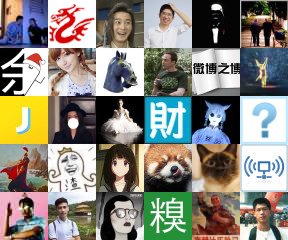

In [88]:
splice_avatar30([userid_to_info[x[0]]['profile_image_url'] for x in users_top])

In [24]:
def show_user_info(x):
    user = userid_to_info[x]
    pprint(user)
#     return Image(url = user['profile_image_url_large'])

In [25]:
show_user_info(users_top[0][0])

{'birthday': '1986-00-00',
 'created_at': 'Wed Jun 20 13:47:49 +0000 2007',
 'description': '会碎念、常刷屏、总笑喷、短时间大量训练数据、多写长文章',
 'favourites_count': 1616,
 'followers_count': 519,
 'following': False,
 'friends_count': 150,
 'gender': '男',
 'id': 'king66lele',
 'location': '北京 朝阳区',
 'name': '逸博',
 'notifications': False,
 'photo_count': 1443,
 'profile_background_color': '#C2E1F3',
 'profile_background_image_url': 'http://static.fanfou.com/img/bg/18.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/s0/00/4f/j5.jpg?1514717703',
 'profile_image_url_large': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/l0/00/4f/j5.jpg?1514717703',
 'profile_link_color': '#2B7FB0',
 'profile_sidebar_border_color': '#E2F1F8',
 'profile_sidebar_fill_color': '#E2F1F8',
 'profile_text_color': '#005077',
 'protected': False,
 'screen_name': '逸博',
 'statuses_count': 22740,
 'unique_id': '~3VZ6nW8IoDY',
 'url': 

In [89]:
# 被引用top20的消息

repost_top = get_top([x['repost_status']['id'] for x in statuses if 'repost_status' in x], num=20)
for i in range(len(repost_top)):
    x = repost_top[i]
    for y in statuses:
        if 'repost_status' in y and y['repost_status']['id'] == x[0]:
            repost_top[i] = ('id: '+y['repost_status']['user']['id'] + ' name: '+y['repost_status']['user']['name']  +' '+ html.unescape(y['repost_status']['text']),x[0], x[1],x[2])
            break
            
pprint(repost_top)

[('id: ningqun name: 一介大叔 @医生妈妈欧茜 '
  '：这轮自媒体整治，已封杀了9800个号，咋说呢，医学谈深了，就涉及法律；历史谈深了，就涉及政治；经济谈深了，就涉及政策；艺术谈深了，就涉及价值取向；人文谈深了，就涉及思想道德。看来看去，还是谈点风花雪月、演艺娱乐的安全。',
  'DrohSWndHTc',
  83,
  0.11527777777777778),
 ('id: fyjdyl name: 饭友经典语录 '
  '“生产不起也消费不起欲望的年轻人，只好自修成佛。”一篇自媒体文章的标题，关于所谓的“佛系”，可以算是一针见血了……',
  'N91srpqg0Js',
  49,
  0.06805555555555555),
 ('id: wangxing name: 王兴 社交媒体和自媒体火了之后，确实是：传谣动动嘴，辟谣跑断腿。',
  'mSHMtfGkJic',
  40,
  0.05555555555555555),
 ('id: izlmichael name: 张亮 感觉昨天有几千个自媒体徘徊在饭否，就像外国媒体堵在新闻当事人门前。',
  'U39tRpIeKvY',
  35,
  0.04861111111111111),
 ('id: withmaxi name: 演良 '
  '冷静下来考虑一下，你为什么想要护肤、美容、读书、健身、挣钱、升职、自律、学习？你以为一切来自自我意愿，可事实上这一切来自社会、来自媒体、来自国家和邻居，可能来自外界的一切，但绝不源于你。',
  'g6BniWP2G8o',
  29,
  0.04027777777777778),
 ('id: izlmichael name: 张亮 '
  '十次里有九次，我厌恶一个自媒体，不是因其专业能力，而是它的三观卑劣，把自己的恶念、坏心眼和狭隘包装起来传播。自媒体很容易这样，因为危言耸听容易获得流量，且不像传统媒体有机制和其他人意见制衡。本来做菜的，最后发现做屎更容易赚钱，就去吐屎了，中国这样的事常见。',
  'OSpKSSUrWXE',
  26,
  0.03611111111111111),
 ('id: aristotle name: 春燈 '
  '很多有意思的故事、观点甚或是独特的视角带来的不同体验，只要肯耐心地往

In [90]:
# 被引用top20的人
repost_user_id_top = get_top([x['repost_status']['user']['id'] for x in statuses if 'repost_status' in x], num=30)
repost_name_top =  [ (userid_to_info[x[0]]['name'] , x[1], x[2],  x[0]) for x in repost_user_id_top]
pprint(repost_name_top)

[('一介大叔', 90, 0.125, 'ningqun'),
 ('王兴', 83, 0.11527777777777778, 'wangxing'),
 ('张亮', 61, 0.08472222222222223, 'izlmichael'),
 ('饭友经典语录', 59, 0.08194444444444444, 'fyjdyl'),
 ('演良', 29, 0.04027777777777778, 'withmaxi'),
 ('形散神更散', 26, 0.03611111111111111, 'wanzi660'),
 ('春燈', 24, 0.03333333333333333, 'aristotle'),
 ('太吾驴', 20, 0.027777777777777776, '周余'),
 ('闽南大翠花', 17, 0.02361111111111111, 'yizhihua'),
 ('即刻精选', 12, 0.016666666666666666, 'jike_bot'),
 ('东东枪', 9, 0.0125, 'dongdongqiang'),
 ('玉米小官人', 8, 0.011111111111111112, 'shuchang.cn'),
 ('左堂堂', 8, 0.011111111111111112, 'bb0813'),
 ('李时珍的皮', 8, 0.011111111111111112, '闻言文'),
 ('倒逆河流', 7, 0.009722222222222222, 'waygn'),
 ('王金牙', 6, 0.008333333333333333, 'shiziwang'),
 ('勥的泥石流资本', 6, 0.008333333333333333, 'raiden_'),
 ('帮主胡子', 6, 0.008333333333333333, 'huzibeer'),
 ('弥勒儿', 6, 0.008333333333333333, 'xiaoyouzhi'),
 ('远骋', 5, 0.006944444444444444, 'yuancheng'),
 ('阪本', 5, 0.006944444444444444, 'sakamotosan'),
 ('纯圆鹅', 5, 0.00694444444444

100%|██████████| 5/5 [00:17<00:00,  2.86s/it]


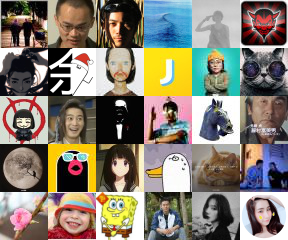

In [91]:
splice_avatar30([userid_to_info[x[0]]['profile_image_url'] for x in repost_user_id_top])

In [92]:
# top20 gender
gender_top = get_top([x['user']['gender'] or '未知' for x in statuses ], num=20)
pprint(gender_top)
huabing(gender_top)

[('男', 1324, 0.48910232729959363),
 ('未知', 821, 0.3032877724418175),
 ('女', 562, 0.20760990025858883)]


In [93]:
# converter = {
#     'Jiangsu Sheng' : '江苏',
#     'Shandong Sheng' : '山东',
#     'Shanghai Shi' : '上海',
#     'Beijing' : '北京',
#     'Fujian': '福建',
#     'Guangxi Zhuangzu Zizhiqu': '广西',
#     'Yunnan': '云南',
#     'Tianjin Shi': '天津',
#     'Zhejiang Sheng' : '浙江',
#     'Guangdong': '广东',
#     'Sichuan': '四川',
#     'Hebei': '河北',
#     'TW': '台湾',
#     'Liaoning': '辽宁',
#     'Hunan': '湖南',
#     'Changchun Shi': '长春',
#     'KR' : '韩国',
#     'Henan Sheng': '河南',
#     'Shanxi Sheng': '山西',
#     'Jilin Sheng': '吉林',
#     'Anhui Sheng': '安徽',
#     'Heilongjiang Sheng': '黑龙江',
#     'Jiangxi Sheng': '江西',
#     'ES': '西班牙',
#     'Hubei': '湖北',
#     'SJ' : '斯瓦尔巴群岛和扬马延岛',
#     'Shaanxi': '陕西',
#     'Gansu Sheng': '甘肃',
#     'HK': '香港',
#     'CA' : '加拿大',
#     'Xinjiang Uygur Zizhiqu': '新疆',
#     'JP' : '日本',
# }
# torch.save(converter, 'geocoverter-en-cn.torch.pkl')

In [94]:
# top20 location

converter = torch.load('geocoverter-en-cn.torch.pkl')
def geotransform(x):
    if len(x) == 0:
        return '未知'
    if ',' in x and len(x.split(',')) == 2:
        try:
            a = x.split(',')
            results = rg.search((float(a[0]),float(a[1]))) # default mode = 2
            if len(results) == 0:
                return '未知'
            if results[0]['cc'] == 'CN':
                if results[0]['admin1'] in converter:
                    return converter[results[0]['admin1']]
                print('\n',len(results[0]['admin1']),results[0],'\n')
                return results[0]['admin1']
            else:
                if results[0]['cc'] in converter:
                    return converter[results[0]['cc']]
                print('\n',len(results[0]['cc']),results[0],'\n')
                return results[0]['cc']
        except Exception as e:
            print(x)
            return '未知'
    if ' ' in x and len(x.split(' ')) == 2:
        return x.split(' ')[0]
    return x
    
location_top = get_top([geotransform(x['location']) for x in tqdm(statuses)], num=20)
pprint(location_top)
huabing(location_top)

100%|██████████| 2707/2707 [00:07<00:00, 381.62it/s] 

[('未知', 996, 0.3679349833764315),
 ('北京', 449, 0.16586627262652381),
 ('广东', 253, 0.09346139637975619),
 ('上海', 177, 0.06538603620243813),
 ('江苏', 61, 0.022534170668636867),
 ('浙江', 56, 0.020687107499076467),
 ('四川', 54, 0.01994828223125231),
 ('湖北', 50, 0.01847063169560399),
 ('福建', 48, 0.01773180642777983),
 ('山东', 47, 0.01736239379386775),
 ('海外', 38, 0.014037680088659032),
 ('辽宁', 31, 0.011451791651274473),
 ('河南', 31, 0.011451791651274473),
 ('陕西', 29, 0.010712966383450314),
 ('天津', 29, 0.010712966383450314),
 ('重庆', 24, 0.008865903213889916),
 ('黑龙江', 17, 0.006280014776505356),
 ('湖南', 17, 0.006280014776505356),
 ('广西', 13, 0.004802364240857037),
 ('安徽', 12, 0.004432951606944958)]


In [95]:
def remove_atag(s):
    if '<a' not in s:
        return s
    start = s.find('>')
    end = s.find('</a>',start)
    return s[start+1:end]

In [96]:
# top20 source
source_top = get_top([remove_atag(x['source']) for x in statuses ], num=20)
pprint(source_top)
huabing(source_top)

[('网页', 762, 0.2814924270410048),
 ('御飯 iOS', 271, 0.10011082379017362),
 ('猫饭', 197, 0.07277428888067972),
 ('「御飯 iPhone」', 181, 0.06686368673808644),
 ('Android客户端', 175, 0.06464721093461397),
 ('享拍微博通', 171, 0.06316956039896564),
 ('手机上网', 103, 0.03804950129294422),
 ('蘑菇饭', 92, 0.03398596231991134),
 ('FaWave', 68, 0.025120059106021424),
 ('API', 60, 0.02216475803472479),
 ('尚饭', 58, 0.021425932766900628),
 ('有饭', 57, 0.02105652013298855),
 ('FFReeder', 44, 0.01625415589213151),
 ('炒饭', 39, 0.014407092722571112),
 ('饭否分享', 32, 0.011821204285186553),
 ('饭团fantuan', 32, 0.011821204285186553),
 ('Twidere', 31, 0.011451791651274473),
 ('泡饭', 29, 0.010712966383450314),
 ('iPhone客户端', 26, 0.009604728481714075),
 ('小饭', 25, 0.009235315847801994)]


In [36]:
# nlp part

In [97]:
def myfilter(s):
    s = s.replace('<strong>','')
    s = s.replace('</strong>','')
    while '转@' in s:
        pos = s.find('转@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@']:
            end2 = s.find(endsym,pos+2)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [转@] too long',s)
            s = s[:pos] + s[pos+2:]
        else:
            s = s[:pos] + s[end:]
    while '@' in s:
        pos = s.find('@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@', '\n']:
            end2 = s.find(endsym,pos+1)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [@] too long',s)
            s = s[:pos] + s[pos+1:]
        else:
            s = s[:pos] + s[end:]
    if '@' in s:
        print('alert @ in ', s)
    return s

In [98]:
sentences = []
for x in tqdm(statuses):
    s = html.unescape(x['text']) 
    s = myfilter(s)
    if keyword not in s:
        continue
    if '</' in s:
        print(s)
    ss = SentenceSplitter.split(s)
    for t in ss:
        if len(t) > 4:
            sentences.append(t)
    

 42%|████▏     | 1137/2707 [00:00<00:02, 708.96it/s]

alert [@] too long 微路：翻译脱口秀之类自媒体是不是也要凉了.....//@goldcrest-可爱萌萌教星星眼教主:“网络视听节目服务单位可供播出的境外电影、电视剧、动画片、纪录片和其他境外电视节目，不得超过该类别可供播出节目总量的30%“
alert [@] too long 以前厕所里都会放一摞故事会啥的，催便。我建议新时代，厕所革命也要靠自媒体。以后公共厕所只需要设置个屏幕，只放@北美吐槽君的微博。改革嘛，就是要让人民群众真正有获得感。


100%|██████████| 2707/2707 [00:00<00:00, 4765.61it/s]

alert [@] too long 【#电子商务#---#80后#+#微关注#---中国互联网是否从 BAT 时代进入了双寡头时代？】文/@手稿2012腾讯用易迅和微信入口换来了京东15%的股权，一大波自媒体说这是布局。马云60亿港币盘下了一家背景复杂的文化公司，一大波自媒体也说这是布局。大... http://w
alert [@] too long 【第一款基于"自媒体"的聚合阅读APP推出】今日，博闻中国（@UBMChina）宣布携手易博天下科技针对商业科技领域的决策人群，推出以自媒体作者为基础的兴趣阅读移动聚合应用 -- @商业科技微报。首次采用以文章作者而不是媒体平台为中心的内容呈现模式，根据用户兴趣匹配推荐内容。 h
alert [@] too long 【第一款基于"自媒体"的聚合阅读APP推出】今日，博闻中国（UBMChina）宣布携手易博天下科技针对商业科技领域的决策人群，推出以自媒体作者为基础的兴趣阅读移动聚合应用 -- @商业科技微报。首次采用以文章作者而不是媒体平台为中心的内容呈现模式，根据用户兴趣匹配推荐内容。 h
alert [@] too long 【我的微信公众账号】“呛嘴大金牙”是适度闷骚小小害羞纯情可爱偶尔唏嘘的奇男子（这年头拼的就是国际化头衔！）——王瑞的自媒体（微博@王金牙儿）。内容一会儿正经一会儿不正经，绝不无聊，不信订阅试试！
alert [@] too long #京师公益讲堂# 5月8日19:00-21:00，北师大敬文讲堂，自媒体从业者、爱心衣橱基金发起人、基金管委会主席王凯将做客第十八期【京师公益讲堂】，畅谈“爱心衣橱的发展与公益新模式的探索”。您可以编辑姓名、电话、单位、职务发送到cc@bnu1.org报名，活动免费公开。详见ht
alert [@] too long #京师公益讲堂# 5月8日19:00-21:00，北师大敬文讲堂，自媒体从业者、爱心衣橱基金发起人、基金管委会主席王凯将做客第十八期【京师公益讲堂】，畅谈“爱心衣橱的发展与公益新模式的探索”。您可以编辑姓名、电话、单位、职务发送到cc@bnu1.org报名，活动免费公开。详见ht
alert [@] too long #京师公益讲堂# 5月8日19:00-21:00，北师大敬文讲堂，自媒体从业者、爱心衣橱基金发起人、基金管委会主席王凯将做客第十八

In [99]:
print(len(sentences))

6503


In [116]:
get_top(sentences,num=20)

[('经济谈深了，就涉及政策；', 84, 0.012917115177610334),
 ('历史谈深了，就涉及政治；', 84, 0.012917115177610334),
 ('艺术谈深了，就涉及价值取向；', 81, 0.012455789635552822),
 ('人文谈深了，就涉及思想道德。', 74, 0.01137936337075196),
 ('：这轮自媒体整治，已封杀了9800个号，咋说呢，医学谈深了，就涉及法律；', 52, 0.00799630939566354),
 ('看来看去，还是谈点风花雪月、演艺娱乐的安全。', 52, 0.00799630939566354),
 ('一篇自媒体文章的标题，关于所谓的“佛系”，可以算是一针见血了……', 50, 0.007688759034291865),
 ('“生产不起也消费不起欲望的年轻人，只好自修成佛。”', 39, 0.005997232046747655),
 ('社交媒体和自媒体火了之后，确实是：传谣动动嘴，辟谣跑断腿。', 39, 0.005997232046747655),
 ('化缘改叫众筹，算命改叫分析师，八卦小报改叫自媒体，统计改叫大数据分析， 忽悠改叫互联网思维，做耳机的改为可穿戴设备，IDC叫云计算，办公室出租叫孵化器，圈地盖楼叫科技园区，放高利贷叫资本运作，借钱给朋友叫天使投资。',
  36,
  0.005535906504690143),
 ('你以为一切来自自我意愿，可事实上这一切来自社会、来自媒体、来自国家和邻居，可能来自外界的一切，但绝不源于你。',
  30,
  0.004613255420575119),
 ('自媒体很容易这样，因为危言耸听容易获得流量，且不像传统媒体有机制和其他人意见制衡。', 25, 0.0038443795171459326),
 ('中老年会发养生，社会造谣，佛学和名言。', 25, 0.0038443795171459326),
 ('就是年轻人会发演唱会，电影节，旅游，color run。', 25, 0.0038443795171459326),
 ('他们共同重新构建了九十年代的两毛钱一份的晚报副刊，自己当上了主编。', 24, 0.003690604336460095),
 ('什么是自媒体时代？', 24, 

In [100]:
# 对sentences去重。。 拒绝转发的影响 （存疑？）
# 不去重

In [101]:
# sentences = list(set(sentences))

In [102]:
print(len(list(set(sentences))))

4628


In [103]:
# torch.save(['尼玛', '卧槽', '傻逼', '对了', '有木有', '他妈'],'blacklist.torch.pkl' )
def add_to_blacklist(w):
    global blacklist
    blacklist = torch.load('blacklist.torch.pkl')
    blacklist.append(w)
    torch.save(blacklist,'blacklist.torch.pkl')

In [104]:
# 无意义
blacklist = torch.load('blacklist.torch.pkl')

In [105]:
words_all = []

segmentor = Segmentor()
postagger = Postagger()
recognizer = NamedEntityRecognizer()
postagger.load('./ltp_data_v3.4.0/pos.model')
segmentor.load('./ltp_data_v3.4.0/cws.model')
recognizer.load('./ltp_data_v3.4.0/ner.model')

#todo 情感分析

for s in tqdm(sentences):
    words = segmentor.segment(s)
    postags = postagger.postag(words) #词性标注
    netags = recognizer.recognize(words, postags) # 命名实体识别
    for i in range(len(words)):
        if words[i] in blacklist:
            continue
        words_all.append((words[i],postags[i],netags[i]))

segmentor.release()
postagger.release()
recognizer.release()

100%|██████████| 6503/6503 [00:13<00:00, 488.39it/s]


In [106]:
print(len(words_all))

141027


In [107]:
# get_top([x[0] for x in words_all if len(x[0])>1 and x[1]!='wp'], num = 25)

In [108]:
posdict = {}
nedict = {}
for x in tqdm(words_all):
    if x[1] not in posdict:
        posdict[x[1]] = []
    if x[2] not in nedict:
        nedict[x[2]] = []
    posdict[x[1]].append(x)
    nedict[x[2]].append(x)

100%|██████████| 141027/141027 [00:00<00:00, 464176.33it/s]


In [109]:
All_interested_words = []
All_interested_words += posdict['i']
All_interested_words += posdict['j']
All_interested_words += posdict['n']
All_interested_words += [x for x in posdict['ws'] if len(x[0])>=4 and not x[0].startswith('http://')]
All_interested_words += posdict['nh']+ nedict['S-Nh']
All_interested_words += posdict['ni']+posdict['nz']+nedict['S-Ns']

In [113]:
inte_top = get_top(All_interested_words, num = 40)

pprint(inte_top)
huabing(inte_top)
','.join([x[0] for x in inte_top])

[('媒体', 3355, 0.10037697462900909),
 ('人', 697, 0.020853279080899952),
 ('微博', 373, 0.011159645763523216),
 ('时代', 360, 0.01077070368597415),
 ('号', 318, 0.009514121589277166),
 ('文章', 289, 0.008646481570129249),
 ('微信', 258, 0.007719004308281475),
 ('新闻', 250, 0.007479655337482049),
 ('互联网', 237, 0.0070907132599329825),
 ('自媒体', 235, 0.007030876017233126),
 ('平台', 225, 0.006731689803733844),
 ('内容', 221, 0.006612015318334131),
 ('公众', 220, 0.006582096696984203),
 ('钱', 166, 0.004966491144088081),
 ('价值', 155, 0.00463738630923887),
 ('信息', 154, 0.0046074676878889425),
 ('中国', 150, 0.00448779320248923),
 ('社会', 146, 0.004368118717089517),
 ('视频', 131, 0.003919339396840593),
 ('网络', 129, 0.0038595021541407374),
 ('数据', 122, 0.00365007180469124),
 ('朋友', 122, 0.00365007180469124),
 ('传统', 118, 0.003530397319291527),
 ('问题', 118, 0.003530397319291527),
 ('公司', 116, 0.0034705600765916706),
 ('经济', 114, 0.0034107228338918143),
 ('广告', 113, 0.0033808042125418863),
 ('标题', 110, 0.0032910483484

'媒体,人,微博,时代,号,文章,微信,新闻,互联网,自媒体,平台,内容,公众,钱,价值,信息,中国,社会,视频,网络,数据,朋友,传统,问题,公司,经济,广告,标题,用户,思维,思想,时候,法律,政策,历史,政治,社交,人文,企业,年轻人'

In [69]:
# 人名

# ['nh'] 人名词
people_top = get_top(posdict['nh']+ nedict['S-Nh'], num=25)
pprint(people_top)
huabing(people_top)

[('毛', 38, 0.02629757785467128),
 ('冯唐', 36, 0.02491349480968858),
 ('毛泽东', 36, 0.02491349480968858),
 ('马', 28, 0.019377162629757784),
 ('罗振宇', 23, 0.01591695501730104),
 ('王凯将', 20, 0.01384083044982699),
 ('史杰鹏', 20, 0.01384083044982699),
 ('罗辑思维', 20, 0.01384083044982699),
 ('老罗', 20, 0.01384083044982699),
 ('金正日', 18, 0.01245674740484429),
 ('伊丽莎白.翠花', 18, 0.01245674740484429),
 ('刘强东', 16, 0.011072664359861591),
 ('王兴', 16, 0.011072664359861591),
 ('爱因斯坦', 14, 0.009688581314878892),
 ('普罗', 12, 0.008304498269896194),
 ('王', 12, 0.008304498269896194),
 ('云', 11, 0.007612456747404845),
 ('罗永浩', 11, 0.007612456747404845),
 ('周滨', 10, 0.006920415224913495),
 ('程苓峰', 10, 0.006920415224913495),
 ('小武', 10, 0.006920415224913495),
 ('梁惠王', 10, 0.006920415224913495),
 ('晨', 10, 0.006920415224913495),
 ('霍金', 10, 0.006920415224913495),
 ('申音', 9, 0.006228373702422145)]


In [68]:
# 组织名

# ['ni'] 组织名
group_top = get_top(posdict['ni']+posdict['nz']+nedict['S-Ns'], num=5)
pprint(group_top)
huabing(group_top)


[('中国', 150, 0.1362397820163488),
 ('新浪', 70, 0.06357856494096276),
 ('云计算', 57, 0.051771117166212535),
 ('腾讯', 44, 0.03996366939146231),
 ('美国', 35, 0.03178928247048138)]


In [ ]:
# details

In [49]:
# 词性
print(posdict.keys())


dict_keys(['v', 'p', 'n', 'r', 'wp', 'u', 'nt', 'c', 'd', 'ws', 'e', 'q', 'nh', 'm', 'i', 'a', 'ns', 'b', 'nd', 'nl', 'k', 'z', 'nz', 'j', 'o', 'ni', 'h'])


In [50]:
# ['i'] 成语
pprint(get_top(posdict['i'], num=25))

[('众筹', 79, 0.07625482625482626),
 ('风花雪月', 68, 0.06563706563706563),
 ('一针见血', 52, 0.05019305019305019),
 ('事实上', 31, 0.029922779922779922),
 ('有意思', 29, 0.027992277992277992),
 ('危言耸听', 26, 0.025096525096525095),
 ('电影节', 25, 0.02413127413127413),
 ('独一无二', 22, 0.021235521235521235),
 ('英雄所见略同', 22, 0.021235521235521235),
 ('没什么', 11, 0.010617760617760617),
 ('无所谓', 11, 0.010617760617760617),
 ('三从四德', 7, 0.006756756756756757),
 ('是的', 7, 0.006756756756756757),
 ('差不多', 7, 0.006756756756756757),
 ('铺天盖地', 7, 0.006756756756756757),
 ('返璞归真', 5, 0.004826254826254826),
 ('世界大战', 5, 0.004826254826254826),
 ('自私自利', 5, 0.004826254826254826),
 ('层出不穷', 5, 0.004826254826254826),
 ('争先恐后', 5, 0.004826254826254826),
 ('他妈的', 5, 0.004826254826254826),
 ('粗制滥造', 5, 0.004826254826254826),
 ('一模一样', 5, 0.004826254826254826),
 ('新年伊始', 4, 0.003861003861003861),
 ('别信', 4, 0.003861003861003861)]


In [51]:

# ['j'] 缩略词
pprint(get_top(posdict['j'], num=25))


[('微博', 84, 0.23931623931623933),
 ('三观卑劣', 26, 0.07407407407407407),
 ('网信办', 15, 0.042735042735042736),
 ('管委会', 10, 0.02849002849002849),
 ('北师大', 10, 0.02849002849002849),
 ('中宣部', 8, 0.022792022792022793),
 ('中超', 6, 0.017094017094017096),
 ('高管', 5, 0.014245014245014245),
 ('央视', 5, 0.014245014245014245),
 ('美', 5, 0.014245014245014245),
 ('建', 4, 0.011396011396011397),
 ('中', 4, 0.011396011396011397),
 ('同比', 4, 0.011396011396011397),
 ('统战', 4, 0.011396011396011397),
 ('川航', 4, 0.011396011396011397),
 ('电商', 4, 0.011396011396011397),
 ('北大', 4, 0.011396011396011397),
 ('高校', 4, 0.011396011396011397),
 ('哈', 4, 0.011396011396011397),
 ('华农', 4, 0.011396011396011397),
 ('京', 4, 0.011396011396011397),
 ('奥运', 3, 0.008547008547008548),
 ('英', 3, 0.008547008547008548),
 ('咪蒙', 3, 0.008547008547008548),
 ('房地产', 3, 0.008547008547008548)]


In [52]:

# ['n'] 名词
pprint(get_top(posdict['n'], num=25))


[('媒体', 3355, 0.1160337552742616),
 ('人', 697, 0.02410596942657536),
 ('时代', 360, 0.01245071591616518),
 ('号', 318, 0.010998132392612575),
 ('文章', 289, 0.009995158054921491),
 ('微博', 286, 0.009891402088953448),
 ('新闻', 250, 0.008646330497336931),
 ('微信', 243, 0.008404233243411496),
 ('互联网', 237, 0.00819672131147541),
 ('自媒体', 235, 0.008127550667496715),
 ('平台', 225, 0.007781697447603237),
 ('内容', 221, 0.0076433561596458465),
 ('公众', 220, 0.007608770837656499),
 ('钱', 166, 0.005741163450231721),
 ('价值', 155, 0.005360724908348897),
 ('信息', 154, 0.005326139586359549),
 ('社会', 146, 0.005049457010444767),
 ('视频', 131, 0.004530677180604552),
 ('网络', 129, 0.004461506536625856),
 ('数据', 122, 0.004219409282700422),
 ('朋友', 122, 0.004219409282700422),
 ('传统', 118, 0.004081067994743031),
 ('问题', 118, 0.004081067994743031),
 ('公司', 116, 0.0040118973507643355),
 ('经济', 114, 0.00394272670678564)]


In [53]:

# ['nh'] 人名词
pprint(get_top(posdict['nh'], num=25))


[('毛', 19, 0.024265644955300127),
 ('冯唐', 18, 0.022988505747126436),
 ('毛泽东', 18, 0.022988505747126436),
 ('马', 14, 0.017879948914431672),
 ('罗振宇', 12, 0.01532567049808429),
 ('云', 11, 0.0140485312899106),
 ('王凯将', 10, 0.01277139208173691),
 ('史杰鹏', 10, 0.01277139208173691),
 ('晨', 10, 0.01277139208173691),
 ('罗辑思维', 10, 0.01277139208173691),
 ('老罗', 10, 0.01277139208173691),
 ('金正日', 9, 0.011494252873563218),
 ('姚', 9, 0.011494252873563218),
 ('伊丽莎白.翠花', 9, 0.011494252873563218),
 ('刘强东', 8, 0.010217113665389528),
 ('王兴', 8, 0.010217113665389528),
 ('爱因斯坦', 7, 0.008939974457215836),
 ('王', 7, 0.008939974457215836),
 ('普罗', 6, 0.007662835249042145),
 ('罗永浩', 6, 0.007662835249042145),
 ('周滨', 5, 0.006385696040868455),
 ('杨', 5, 0.006385696040868455),
 ('申音', 5, 0.006385696040868455),
 ('程苓峰', 5, 0.006385696040868455),
 ('小武', 5, 0.006385696040868455)]


In [54]:

# ['ni'] 组织名
pprint(get_top(posdict['ni'], num=25))


[('新华社', 4, 0.23529411764705882),
 ('微软', 3, 0.17647058823529413),
 ('公安部', 2, 0.11764705882352941),
 ('新媒体', 1, 0.058823529411764705),
 ('联合国', 1, 0.058823529411764705),
 ('清华大学', 1, 0.058823529411764705),
 ('腾讯', 1, 0.058823529411764705),
 ('美联社', 1, 0.058823529411764705),
 ('统战部', 1, 0.058823529411764705),
 ('韩国队', 1, 0.058823529411764705),
 ('日本队', 1, 0.058823529411764705)]


In [55]:

# ['nz'] other proper name
pprint(get_top(posdict['nz'], num=25))


[('新浪', 70, 0.1346153846153846),
 ('云计算', 57, 0.10961538461538461),
 ('腾讯', 43, 0.08269230769230769),
 ('百度', 33, 0.06346153846153846),
 ('淘宝', 24, 0.046153846153846156),
 ('搜狐', 18, 0.03461538461538462),
 ('微信', 15, 0.028846153846153848),
 ('阿里巴巴', 12, 0.023076923076923078),
 ('360', 11, 0.021153846153846155),
 ('80后', 10, 0.019230769230769232),
 ('京东', 10, 0.019230769230769232),
 ('推特', 8, 0.015384615384615385),
 ('中文', 7, 0.013461538461538462),
 ('花旗', 7, 0.013461538461538462),
 ('人民日报', 6, 0.011538461538461539),
 ('搜狗', 6, 0.011538461538461539),
 ('星巴克', 6, 0.011538461538461539),
 ('视讯网', 5, 0.009615384615384616),
 ('万科', 5, 0.009615384615384616),
 ('英语', 5, 0.009615384615384616),
 ('恒大', 4, 0.007692307692307693),
 ('网易', 4, 0.007692307692307693),
 ('中新网', 3, 0.0057692307692307696),
 ('茅台', 3, 0.0057692307692307696),
 ('福特', 3, 0.0057692307692307696)]


In [56]:

# ['v'] verb len >= 2
# pprint(get_top([x for x in posdict['v'] if len(x[0])>=2], num=25))


In [57]:

# foreign words	
pprint(get_top([x for x in posdict['ws'] if len(x[0])>=4 and not x[0].startswith('http://')], num=25))


[('color', 25, 0.043327556325823226),
 ('Twitter', 15, 0.025996533795493933),
 ('Ustream.tv', 12, 0.02079722703639515),
 ('Facebook', 11, 0.019064124783362217),
 ('ccbnu1.org', 10, 0.01733102253032929),
 ('Lofter', 8, 0.01386481802426343),
 ('YouTube', 8, 0.01386481802426343),
 ('web2.0', 7, 0.012131715771230503),
 ('papi', 7, 0.012131715771230503),
 ('Excuse', 7, 0.012131715771230503),
 ('Open', 7, 0.012131715771230503),
 ('Stickam', 6, 0.010398613518197574),
 ('Blogtv', 6, 0.010398613518197574),
 ('Justin.tv', 6, 0.010398613518197574),
 ('facebook', 6, 0.010398613518197574),
 ('iPad', 5, 0.008665511265164644),
 ('rdquo', 5, 0.008665511265164644),
 ('ldquo', 5, 0.008665511265164644),
 ('Google', 5, 0.008665511265164644),
 ('Opinions', 5, 0.008665511265164644),
 ('Ideas', 5, 0.008665511265164644),
 ('Style', 5, 0.008665511265164644),
 ('Elements', 5, 0.008665511265164644),
 ('weibo', 5, 0.008665511265164644),
 ('Storify', 4, 0.006932409012131715)]


In [58]:
# 命名实体
print(nedict.keys())


dict_keys(['O', 'S-Nh', 'B-Ni', 'E-Ni', 'S-Ns', 'B-Ns', 'E-Ns', 'I-Ni', 'S-Ni', 'B-Nh', 'E-Nh', 'I-Ns', 'I-Nh'])


In [59]:


# 人名
pprint(get_top(nedict['S-Nh'], num=25))


[('毛', 19, 0.028700906344410877),
 ('冯唐', 18, 0.027190332326283987),
 ('毛泽东', 18, 0.027190332326283987),
 ('马', 14, 0.021148036253776436),
 ('罗振宇', 11, 0.01661631419939577),
 ('王凯将', 10, 0.015105740181268883),
 ('史杰鹏', 10, 0.015105740181268883),
 ('罗辑思维', 10, 0.015105740181268883),
 ('老罗', 10, 0.015105740181268883),
 ('金正日', 9, 0.013595166163141994),
 ('伊丽莎白.翠花', 9, 0.013595166163141994),
 ('刘强东', 8, 0.012084592145015106),
 ('王兴', 8, 0.012084592145015106),
 ('爱因斯坦', 7, 0.010574018126888218),
 ('普罗', 6, 0.00906344410876133),
 ('周滨', 5, 0.0075528700906344415),
 ('程苓峰', 5, 0.0075528700906344415),
 ('小武', 5, 0.0075528700906344415),
 ('梁惠王', 5, 0.0075528700906344415),
 ('霍金', 5, 0.0075528700906344415),
 ('王', 5, 0.0075528700906344415),
 ('罗永浩', 5, 0.0075528700906344415),
 ('丁小云', 4, 0.006042296072507553),
 ('申音', 4, 0.006042296072507553),
 ('方舟子', 4, 0.006042296072507553)]


In [63]:

# # 机构名 被 ni替代
# pprint(get_top(nedict['S-Ni'], num=25))


In [64]:

# 地名
pprint(get_top(nedict['S-Ns'], num=25))

[('中国', 150, 0.26595744680851063),
 ('美国', 35, 0.06205673758865248),
 ('北京', 34, 0.06028368794326241),
 ('舟山', 12, 0.02127659574468085),
 ('京东', 12, 0.02127659574468085),
 ('日本', 11, 0.01950354609929078),
 ('上海', 10, 0.01773049645390071),
 ('喜马拉雅', 9, 0.015957446808510637),
 ('阿里', 9, 0.015957446808510637),
 ('云南', 7, 0.012411347517730497),
 ('广东', 7, 0.012411347517730497),
 ('香港', 7, 0.012411347517730497),
 ('深圳', 7, 0.012411347517730497),
 ('三里屯', 7, 0.012411347517730497),
 ('俄罗斯', 7, 0.012411347517730497),
 ('重庆', 6, 0.010638297872340425),
 ('欧洲', 6, 0.010638297872340425),
 ('南美', 6, 0.010638297872340425),
 ('广州', 6, 0.010638297872340425),
 ('新疆', 5, 0.008865248226950355),
 ('英国', 5, 0.008865248226950355),
 ('朝鲜', 5, 0.008865248226950355),
 ('美', 5, 0.008865248226950355),
 ('中', 4, 0.0070921985815602835),
 ('青岛', 4, 0.0070921985815602835)]


In [62]:
# 以上内容均为自动生成...